<a href="https://colab.research.google.com/github/Heaven-Bro/210152_cnn/blob/main/210152_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!git clone https://github.com/Heaven-Bro/210152_cnn.git
%cd 210152_cnn

import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3
batch_size = 64
num_epochs = 15
learning_rate = 0.001
img_size = 64

mean = (0.5,)
std = (0.5,)

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [8]:

train_dir = "data/train"
val_dir   = "data/val"
test_dir  = "data/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=test_transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=test_transform)

class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


Classes: ['circles', 'squares', 'triangles']


In [19]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def evaluate(loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [12]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_acc = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Epoch [1/15] Train Loss: 1.1310 Acc: 0.2967 | Val Loss: 1.0969 Acc: 0.3633
Epoch [2/15] Train Loss: 1.0975 Acc: 0.3533 | Val Loss: 1.0913 Acc: 0.4633
Epoch [3/15] Train Loss: 1.0866 Acc: 0.5000 | Val Loss: 1.0661 Acc: 0.4100
Epoch [4/15] Train Loss: 1.0471 Acc: 0.4267 | Val Loss: 1.0001 Acc: 0.5900
Epoch [5/15] Train Loss: 0.9622 Acc: 0.5633 | Val Loss: 0.8995 Acc: 0.5600
Epoch [6/15] Train Loss: 0.8967 Acc: 0.5967 | Val Loss: 0.8403 Acc: 0.5867
Epoch [7/15] Train Loss: 0.8633 Acc: 0.5900 | Val Loss: 0.8172 Acc: 0.6800
Epoch [8/15] Train Loss: 0.7973 Acc: 0.6600 | Val Loss: 0.7178 Acc: 0.6833
Epoch [9/15] Train Loss: 0.6807 Acc: 0.7100 | Val Loss: 0.6089 Acc: 0.7533
Epoch [10/15] Train Loss: 0.5646 Acc: 0.7667 | Val Loss: 0.5128 Acc: 0.7967
Epoch [11/15] Train Loss: 0.4623 Acc: 0.8267 | Val Loss: 0.3785 Acc: 0.8800
Epoch [12/15] Train Loss: 0.3599 Acc: 0.8667 | Val Loss: 0.2625 Acc: 0.9267
Epoch [13/15] Train Loss: 0.2521 Acc: 0.9267 | Val Loss: 0.1845 Acc: 0.9533
Epoch [14/15] Train L

Model saved to model/210152.pth


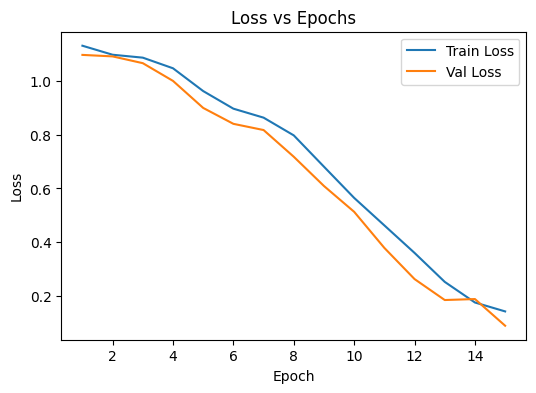

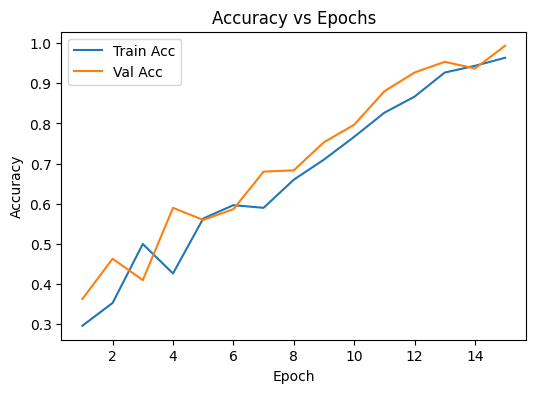

In [13]:

os.makedirs("model", exist_ok=True)
model_path = "model/210152.pth"
torch.save(model.state_dict(), model_path)
print("Model saved to", model_path)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


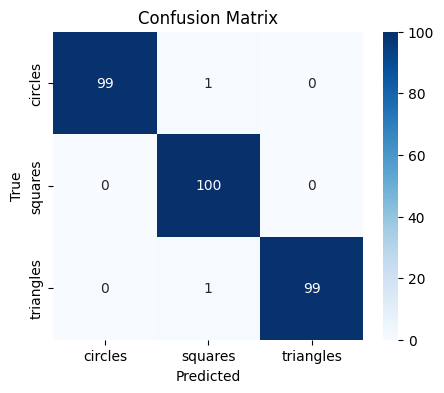

In [14]:

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


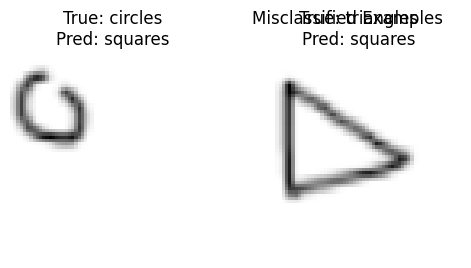

In [15]:

mis_images = []
mis_true = []
mis_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        mismatch = preds != labels
        if mismatch.any():
            for img, t, p, m in zip(images, labels, preds, mismatch):
                if m:
                    mis_images.append(img.cpu())
                    mis_true.append(t.cpu().item())
                    mis_pred.append(p.cpu().item())
                if len(mis_images) >= 3:
                    break
        if len(mis_images) >= 3:
            break

plt.figure(figsize=(9, 3))
for i in range(len(mis_images)):
    img = mis_images[i]
    img = img.squeeze(0)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"True: {class_names[mis_true[i]]}\nPred: {class_names[mis_pred[i]]}")
plt.suptitle("Misclassified Examples")
plt.show()


In [17]:

loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load("model/210152.pth", map_location=device))
loaded_model.eval()


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

Found phone images: ['dataset/circle1.jpeg', 'dataset/circle2.jpeg', 'dataset/circle3.jpeg', 'dataset/square1.jpeg', 'dataset/square2.jpeg', 'dataset/square3.jpeg', 'dataset/square4.jpeg', 'dataset/triangle1.jpeg', 'dataset/triangle2.jpeg', 'dataset/triangle3.jpeg']
dataset/circle1.jpeg -> triangles (100.00%)
dataset/circle2.jpeg -> triangles (100.00%)
dataset/circle3.jpeg -> squares (100.00%)
dataset/square1.jpeg -> squares (96.24%)
dataset/square2.jpeg -> triangles (99.71%)
dataset/square3.jpeg -> triangles (71.74%)
dataset/square4.jpeg -> circles (51.97%)
dataset/triangle1.jpeg -> circles (99.81%)
dataset/triangle2.jpeg -> squares (94.49%)
dataset/triangle3.jpeg -> squares (72.87%)


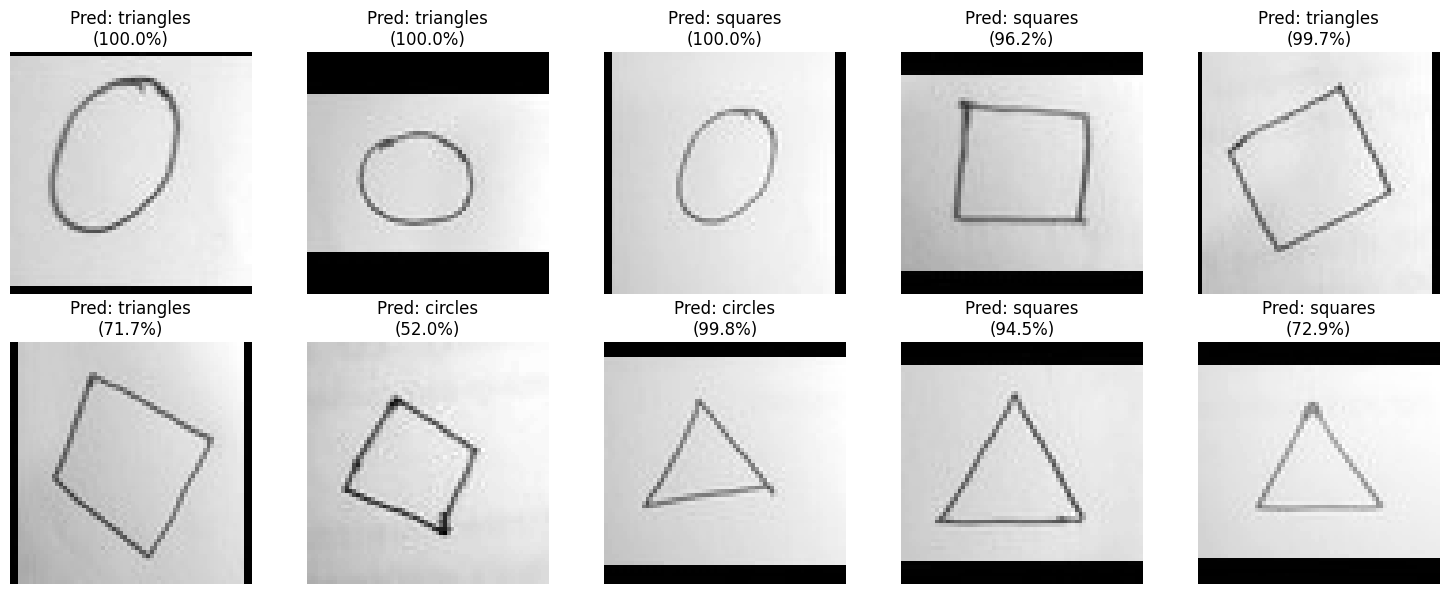

In [18]:

phone_dir = "dataset"
image_paths = sorted(glob.glob(os.path.join(phone_dir, "*.*")))

print("Found phone images:", image_paths)

def preprocess_image(path):
    img = Image.open(path).convert("L")
    img = test_transform(img)
    img = img.unsqueeze(0)
    return img.to(device)

def predict_image(path):
    img_tensor = preprocess_image(path)
    with torch.no_grad():
        outputs = loaded_model(img_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        conf, pred_idx = torch.max(probs, 0)
    return class_names[pred_idx.item()], conf.item() * 100

predictions = []
for p in image_paths:
    pred_label, conf = predict_image(p)
    predictions.append((p, pred_label, conf))
    print(f"{p} -> {pred_label} ({conf:.2f}%)")


n = len(image_paths)
cols = 5
rows = int(np.ceil(n / cols)) if n > 0 else 1

plt.figure(figsize=(3 * cols, 3 * rows))
for i, (path, pred_label, conf) in enumerate(predictions):
    img = Image.open(path).convert("L")
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Pred: {pred_label}\n({conf:.1f}%)")
plt.tight_layout()
plt.show()
